# Predicting bike rentals

This project will use linear regression and decision tree to create models to predict the number of bikes rental in a period. Will use data from the bike_retal_house.csv to fit he model.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
bike_rental = pd.read_csv('bike_rental_hour.csv', index_col = 'instant')
bike_rental.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


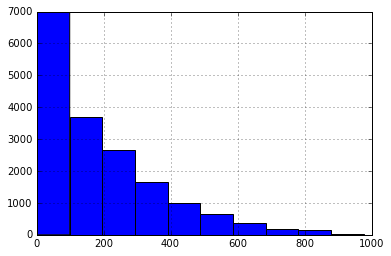

In [3]:
bike_rental.cnt.hist()
plt.show()

The column hr (hour) has too much variation and the random forest will treat each hour in a way. But there isn't many diferences between 4 pm and 5 pm. To correct it will be set time periods of 6 hours as morning, afternoon, night and dawn as 1, 2, 3 and 4 respectively.

In [4]:
hour_dict = {}
for i in range(0, 6):
    hour_dict[i] = 4
    hour_dict[i + 6] = 1
    hour_dict[i + 12] = 2
    hour_dict[i + 18] = 3

bike_rental['time_label'] = bike_rental.hr.map(hour_dict)

To be capable of appling the machine learning algorithms it is necessary split the data between train and test.

In [5]:
train, test = train_test_split(bike_rental, test_size = 0.2,
                               random_state = 1)

Now it is necessary select the features columns. Will be the columns with higher absolute correlation with cnt. The sum of the columns casual and registered is equal to cnt, so dosen't make sense to insert this column in the training. The column dteday is only the date so will be not used and the column hour will be removed because of the time_label.

In [6]:
correlation = bike_rental.corr().cnt.abs().sort_values().drop(['casual', 'registered', 'cnt', 'hr'])
correlation

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
hum           0.322911
time_label    0.378318
atemp         0.400929
temp          0.404772
Name: cnt, dtype: float64

In [57]:
features = list(correlation[correlation > 0].index)

# Linear Regression

It the columns chosen it is possible fit the model and make predictions.

In [58]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
predictionsLr = lr.predict(test[features])
mseLr = mean_squared_error(predictionsLr, test['cnt'])
rmseLr = mseLr**0.5

# root mean squared error
rmseLr

139.9707787881428

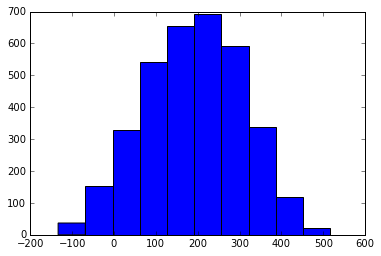

In [60]:
plt.hist(predictionsLr)
plt.show()

The root of squared error seems to bem little but looking to the histogram of the model is far away from ideal. The prediction has many values that are less than 0. This values are impossible in reality

# Decision Tree

In [61]:
dt = DecisionTreeRegressor()
dt.fit(train[features], train['cnt'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [62]:
predictionsDt = dt.predict(test[features])

mseDt = mean_squared_error(predictionsDt, test['cnt'])
rmseDt = mseDt**0.5

# root mean squared error
rmseDt

152.02498355848937

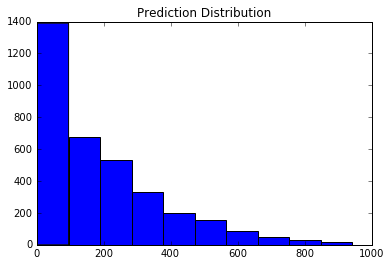

In [63]:
plt.hist(predictionsDt)
plt.title("Prediction Distribution")
plt.show()

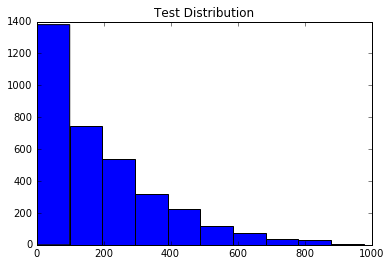

In [64]:
plt.hist(test['cnt'])
plt.title('Test Distribution')
plt.show()

The root mean squared error is very close from the linear regression. But we can se that the distribuition is far superior and very similar to the test data.

# Random Forest

In [65]:
rf = RandomForestRegressor()
rf.fit(train[features], train['cnt'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [66]:
predictionsRf = rf.predict(test[features])

mseRf = mean_squared_error(predictionsRf, test['cnt'])
rmseRf = mseRf**0.5

# root mean squared error
rmseRf

113.35105577695329

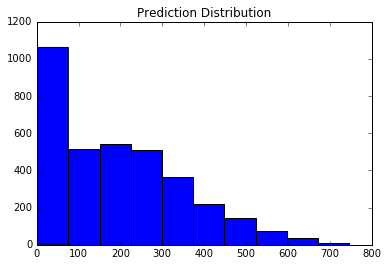

In [67]:
plt.hist(predictionsRf)
plt.title("Prediction Distribution")
plt.show()

The random forest presented smaller root mean squared error and a distribuition simillar to the original.

# Optimization

first will optimize the min_sample_lead parameters, find the value that minimize the error.

In [68]:
values = range(1, 101)
rmselist = list()

for i in values:
    rf = RandomForestRegressor(min_samples_leaf = i)
    rf.fit(train[features], train['cnt'])

    predictionsRf = rf.predict(test[features])

    mseRf = mean_squared_error(predictionsRf, test['cnt'])
    rmseRf = mseRf**0.5
    rmselist.append(rmseRf)

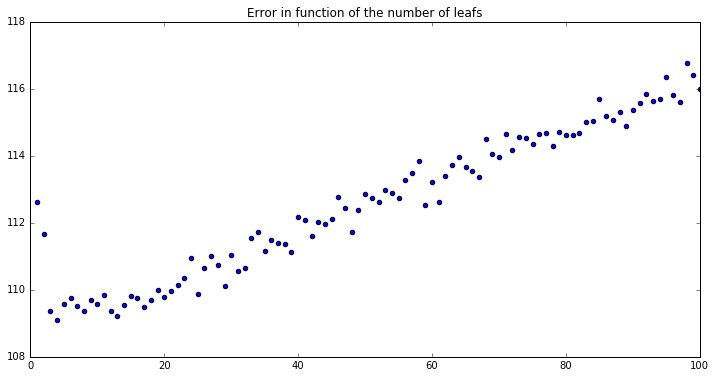

In [69]:
plt.figure(figsize = (12, 6))
plt.scatter(values, rmselist)
plt.title('Error in function of the number of leafs')
plt.xlim(0, 100)
plt.show()

8 leafs seems to be enought to get a good result. Now we can se the number of estimators.

In [70]:
values = range(1, 101)
rmselist = list()

for i in values:
    rf = RandomForestRegressor(min_samples_leaf = 8, n_estimators = i)
    rf.fit(train[features], train['cnt'])

    predictionsRf = rf.predict(test[features])

    mseRf = mean_squared_error(predictionsRf, test['cnt'])
    rmseRf = mseRf**0.5
    rmselist.append(rmseRf)

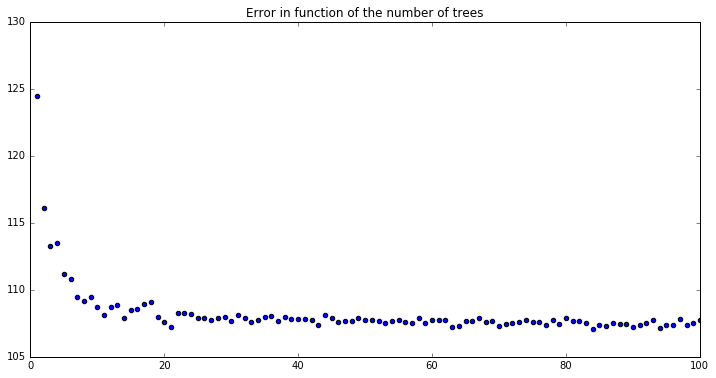

In [71]:
plt.figure(figsize = (12, 6))
plt.scatter(values, rmselist)
plt.title('Error in function of the number of trees')
plt.xlim(0, 100)
plt.show()

20 trees are enought to get a good result. Now lets change max_depth

In [72]:
values = range(1, 101)
rmselist = list()

for i in values:
    rf = RandomForestRegressor(min_samples_leaf = 8, n_estimators = 20, max_depth = i)
    rf.fit(train[features], train['cnt'])

    predictionsRf = rf.predict(test[features])

    mseRf = mean_squared_error(predictionsRf, test['cnt'])
    rmseRf = mseRf**0.5
    rmselist.append(rmseRf)

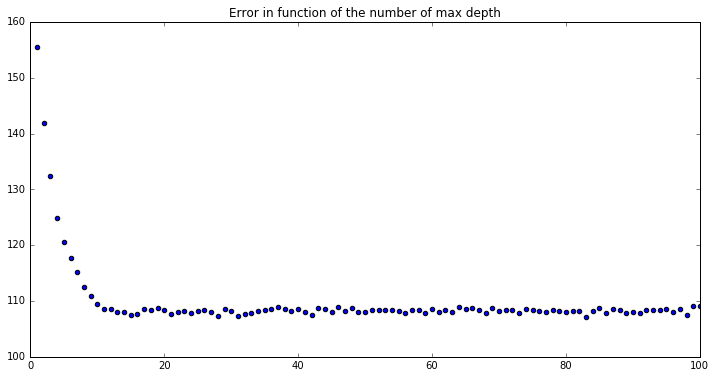

In [73]:
plt.figure(figsize = (12, 6))
plt.scatter(values, rmselist)
plt.title('Error in function of the number of max depth')
plt.xlim(0, 100)
plt.show()

max depth 12 get good results. Now we can check min_sample_split

In [74]:
rf = RandomForestRegressor(min_samples_leaf = 8, n_estimators = 20, max_depth = 12)
rf.fit(train[features], train['cnt'])

predictionsRf = rf.predict(test[features])

mseRf = mean_squared_error(predictionsRf, test['cnt'])
rmseRf = mseRf**0.5
rmseRf

108.68480014942392

was possible to reduce te error from 113 to 108 with feel changes